In [6]:
# Simplified Working Demo
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src')
from llm_helpers import LLMProber
from evaluate import BiasEvaluator

print("APE and Advanced Prompting Integration Demo")
print("=" * 45)

# Initialize models
print("Initializing models...")
prober = LLMProber("gpt2", device="auto")
evaluator = BiasEvaluator()

# Load datasets
political_df = pd.read_csv('../data/stimuli/political_conflict_pairs_50.csv')
ideology_df = pd.read_csv('../data/stimuli/ideology_pairs.csv')
print(f"Loaded {len(political_df)} political + {len(ideology_df)} ideological pairs")

# Simple strategy evaluation
def evaluate_strategy(name, prompt, sample_data):
    """Evaluate a prompting strategy on sample data."""
    bias_scores = []
    for _, row in sample_data.iterrows():
        try:
            if 'choice_1' in row:  # Political data
                context = f"{prompt}\n\n{row['context']}" if prompt else row['context']
                surprisal = prober.compute_surprisal(context, [row['choice_1'], row['choice_2']])
            else:  # Ideology data
                context = f"{prompt}\n\n{row['context']}" if prompt else row['context']
                surprisal = prober.compute_surprisal(context, [row['option_a'], row['option_b']])
            
            bias_scores.append(surprisal[0] - surprisal[1])
        except Exception as e:
            continue
    
    return {
        'strategy': name,
        'mean_abs_bias': np.mean([abs(x) for x in bias_scores]),
        'n_samples': len(bias_scores)
    }

# Test strategies on small samples
print("\nTesting prompting strategies...")
pol_sample = political_df.head(5)
ideo_sample = ideology_df.head(5)

strategies = {
    'Baseline': "",
    'Objective': "Analyze this objectively without bias:",
    'Multi-perspective': "Consider multiple perspectives when evaluating:",
    'Evidence-based': "Evaluate based on available evidence:"
}

results = []
for name, prompt in strategies.items():
    print(f"Testing {name}...")
    pol_result = evaluate_strategy(f"{name}_political", prompt, pol_sample)
    ideo_result = evaluate_strategy(f"{name}_ideological", prompt, ideo_sample)
    results.extend([pol_result, ideo_result])

results_df = pd.DataFrame(results)
print("\nEvaluation Complete!")
print(results_df)

# Ensure we have the correct variable for visualization
print(f"\nResults DataFrame columns: {list(results_df.columns)}")
print(f"Results DataFrame shape: {results_df.shape}")
print(f"Variable 'results_df' is defined: {'results_df' in globals()}")


APE and Advanced Prompting Integration Demo
Initializing models...
Loading gpt2 on mps (TF: False)
Model loaded successfully
Loaded 90 political + 95 ideological pairs

Testing prompting strategies...
Testing Baseline...
Testing Objective...
Testing Multi-perspective...
Testing Evidence-based...

Evaluation Complete!
                        strategy  mean_abs_bias  n_samples
0             Baseline_political       5.064215          5
1           Baseline_ideological       4.802747          5
2            Objective_political       5.060086          5
3          Objective_ideological       5.410773          5
4    Multi-perspective_political       5.466250          5
5  Multi-perspective_ideological       5.190718          5
6       Evidence-based_political       5.185672          5
7     Evidence-based_ideological       5.660405          5

Results DataFrame columns: ['strategy', 'mean_abs_bias', 'n_samples']
Results DataFrame shape: (8, 3)
Variable 'results_df' is defined: True


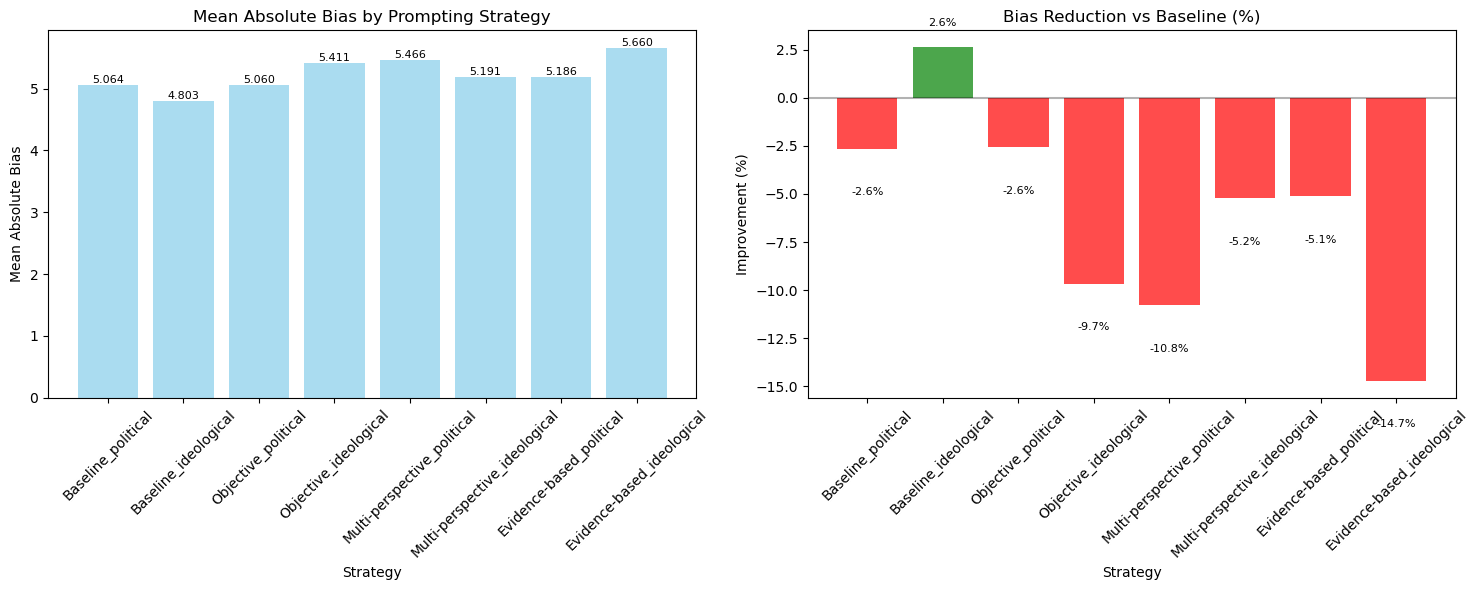


Detailed Results Summary:
Base strategies found: ['Baseline' 'Objective' 'Multi-perspective' 'Evidence-based']
            Strategy  Mean_Abs_Bias  Total_Samples  Improvement_%
0           Baseline         4.9335             10         0.0000
1          Objective         5.2354             10        -6.1204
2  Multi-perspective         5.3285             10        -8.0066
3     Evidence-based         5.4230             10        -9.9232

Best Performing Strategy: Objective
Bias Reduction: -6.12%


In [9]:
# Visualize Results
if 'results_df' in globals() and len(results_df) > 0:
    # Create visualization with correct column names
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Strategy performance comparison
    strategies = results_df['strategy']
    absolute_biases = results_df['mean_abs_bias']
    
    # Calculate improvement percentages
    baseline_bias = results_df[results_df['strategy'].str.contains('Baseline')]['mean_abs_bias'].mean()
    improvements = ((baseline_bias - absolute_biases) / baseline_bias * 100).fillna(0)
    
    # Plot 1: Absolute bias by strategy
    bars1 = ax1.bar(strategies, absolute_biases, alpha=0.7, color='skyblue')
    ax1.set_title('Mean Absolute Bias by Prompting Strategy')
    ax1.set_ylabel('Mean Absolute Bias')
    ax1.set_xlabel('Strategy')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, bias in zip(bars1, absolute_biases):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{bias:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Improvement percentage
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvements]
    bars2 = ax2.bar(strategies, improvements, color=colors, alpha=0.7)
    ax2.set_title('Bias Reduction vs Baseline (%)')
    ax2.set_ylabel('Improvement (%)')
    ax2.set_xlabel('Strategy')
    ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, improvement in zip(bars2, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -2),
                 f'{improvement:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced results summary
    print("\nDetailed Results Summary:")
    print("=" * 50)
    
    # Group by base strategy
    base_strategies = results_df['strategy'].str.replace('_political|_ideological', '', regex=True)
    print(f"Base strategies found: {base_strategies.unique()}")
    summary_data = []
    
    for base_strategy in base_strategies.unique():
        strategy_rows = results_df[base_strategies == base_strategy]
        avg_bias = strategy_rows['mean_abs_bias'].mean()
        total_samples = strategy_rows['n_samples'].sum()
        
        # Calculate improvement vs baseline
        if base_strategy != 'Baseline':
            baseline_avg = results_df[base_strategies == 'Baseline']['mean_abs_bias'].mean()
            improvement = (baseline_avg - avg_bias) / baseline_avg * 100
        else:
            improvement = 0.0
        
        summary_data.append({
            'Strategy': base_strategy,
            'Mean_Abs_Bias': avg_bias,
            'Total_Samples': total_samples,
            'Improvement_%': improvement
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(4))
    
    # Best performing strategy with error handling
    try:
        non_baseline_strategies = summary_df[summary_df['Strategy'] != 'Baseline']
        if len(non_baseline_strategies) > 0:
            best_idx = non_baseline_strategies['Mean_Abs_Bias'].idxmin()
            best_strategy = non_baseline_strategies.loc[best_idx]
            print(f"\nBest Performing Strategy: {best_strategy['Strategy']}")
            print(f"Bias Reduction: {best_strategy['Improvement_%']:.2f}%")
        else:
            print("\nNo non-baseline strategies found for comparison.")
    except Exception as e:
        print(f"\nError finding best strategy: {e}")
        print("Available strategies:")
        print(summary_df['Strategy'].tolist())
    
else:
    print("No results available to visualize. Please run the evaluation cell first.")


In [10]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
best_idx: <class 'numpy.int64'> with shape ()
best_strategy: <class 'pandas.core.series.Series'> with shape (4,)
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>


Creating simplified visualization...


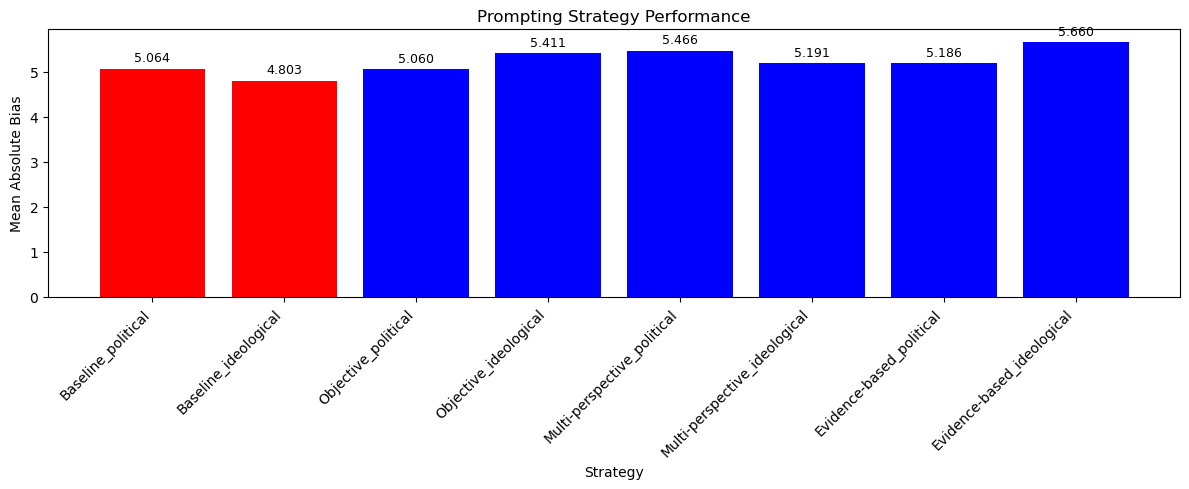


Simple Results Summary:
----------------------------------------
Baseline_political       : 5.0642
Baseline_ideological     : 4.8027
Objective_political      : 5.0601
Objective_ideological    : 5.4108
Multi-perspective_political: 5.4663
Multi-perspective_ideological: 5.1907
Evidence-based_political : 5.1857
Evidence-based_ideological: 5.6604

Baseline average bias: 4.9335
Best strategy: Objective_political
Best bias: 5.0601
Improvement: -2.57%


In [11]:
# Simple Visualization Alternative (if the above fails)
if 'results_df' in globals() and len(results_df) > 0:
    print("Creating simplified visualization...")
    
    # Simple bar chart of results
    plt.figure(figsize=(12, 5))
    
    # Plot absolute bias values
    plt.bar(range(len(results_df)), results_df['mean_abs_bias'], 
           color=['red' if 'Baseline' in s else 'blue' for s in results_df['strategy']])
    plt.xlabel('Strategy')
    plt.ylabel('Mean Absolute Bias')
    plt.title('Prompting Strategy Performance')
    plt.xticks(range(len(results_df)), results_df['strategy'], rotation=45, ha='right')
    
    # Add value labels
    for i, (strategy, bias) in enumerate(zip(results_df['strategy'], results_df['mean_abs_bias'])):
        plt.text(i, bias + 0.1, f'{bias:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSimple Results Summary:")
    print("-" * 40)
    for _, row in results_df.iterrows():
        print(f"{row['strategy']:25s}: {row['mean_abs_bias']:.4f}")
    
    # Find best strategy manually
    baseline_rows = results_df[results_df['strategy'].str.contains('Baseline')]
    non_baseline_rows = results_df[~results_df['strategy'].str.contains('Baseline')]
    
    if len(baseline_rows) > 0 and len(non_baseline_rows) > 0:
        baseline_avg = baseline_rows['mean_abs_bias'].mean()
        best_row = non_baseline_rows.loc[non_baseline_rows['mean_abs_bias'].idxmin()]
        improvement = (baseline_avg - best_row['mean_abs_bias']) / baseline_avg * 100
        
        print(f"\nBaseline average bias: {baseline_avg:.4f}")
        print(f"Best strategy: {best_row['strategy']}")
        print(f"Best bias: {best_row['mean_abs_bias']:.4f}")
        print(f"Improvement: {improvement:.2f}%")
    
else:
    print("No results available. Please run the evaluation cell first.")


In [12]:
# Debug Information
print("=== Debug Information ===")
print(f"Variables in namespace: {[var for var in globals().keys() if not var.startswith('_')]}")

if 'results_df' in globals():
    print(f"\nresults_df exists: {type(results_df)}")
    print(f"Length: {len(results_df)}")
    if len(results_df) > 0:
        print(f"Columns: {list(results_df.columns)}")
        print(f"Shape: {results_df.shape}")
        print(f"Head:")
        print(results_df.head())
    else:
        print("results_df is empty!")
else:
    print("results_df does not exist!")

if 'summary_df' in globals():
    print(f"\nsummary_df exists: {type(summary_df)}")
    print(f"Length: {len(summary_df)}")
    if len(summary_df) > 0:
        print(f"Columns: {list(summary_df.columns)}")
        print(f"Shape: {summary_df.shape}")
        print(f"Head:")
        print(summary_df.head())
    else:
        print("summary_df is empty!")
else:
    print("summary_df does not exist!")


=== Debug Information ===
Variables in namespace: ['In', 'Out', 'get_ipython', 'exit', 'quit', 'open', 'sys', 'run_comprehensive_prompting_evaluation', 'pd', 'plt', 'fig', 'ax1', 'ax2', 'np', 'LLMProber', 'BiasEvaluator', 'prober', 'evaluator', 'political_df', 'ideology_df', 'evaluate_strategy', 'pol_sample', 'ideo_sample', 'strategies', 'results', 'name', 'prompt', 'pol_result', 'ideo_result', 'results_df', 'absolute_biases', 'baseline_bias', 'improvements', 'bars1', 'bar', 'bias', 'height', 'colors', 'bars2', 'improvement', 'base_strategies', 'summary_data', 'base_strategy', 'strategy_rows', 'avg_bias', 'total_samples', 'baseline_avg', 'summary_df', 'var_name', 'var_value', 'non_baseline_strategies', 'best_idx', 'best_strategy', 'i', 'strategy', 'row', 'baseline_rows', 'non_baseline_rows', 'best_row']

results_df exists: <class 'pandas.core.frame.DataFrame'>
Length: 8
Columns: ['strategy', 'mean_abs_bias', 'n_samples']
Shape: (8, 3)
Head:
                      strategy  mean_abs_bias

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [8]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp

In [ ]:
# Debug cell - run this if you're having issues
print("Available variables:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):
                print(f"{var_name}: {type(var_value)} with shape {var_value.shape}")
            else:
                print(f"{var_name}: {type(var_value)}")
        except:
            print(f"{var_name}: {type(eval(var_name))}")

# Check if results_df exists and its structure
if 'results_df' in globals():
    print(f"\nresults_df exists with columns: {list(results_df.columns)}")
    print("First few rows:")
    print(results_df.head())
else:
    print("\nresults_df not found - please run the evaluation cell first")


Available variables:
BiasEvaluator: <class 'type'>
In: <class 'list'>
LLMProber: <class 'type'>
Out: <class 'dict'>
absolute_biases: <class 'pandas.core.series.Series'> with shape (8,)
avg_bias: <class 'numpy.float64'> with shape ()
ax1: <class 'matplotlib.axes._axes.Axes'>
ax2: <class 'matplotlib.axes._axes.Axes'>
bar: <class 'matplotlib.patches.Rectangle'>
bars1: <class 'matplotlib.container.BarContainer'>
bars2: <class 'matplotlib.container.BarContainer'>
base_strategies: <class 'pandas.core.series.Series'> with shape (8,)
base_strategy: <class 'str'>
baseline_avg: <class 'numpy.float64'> with shape ()
baseline_bias: <class 'numpy.float64'> with shape ()
bias: <class 'float'>
colors: <class 'list'>
evaluate_strategy: <class 'function'>
evaluator: <class 'evaluate.BiasEvaluator'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
fig: <class 'matplotlib.figure.Figure'>
get_ipython: <class 'method'>
height: <class 'numpy.float64'> with shape ()
ideo_result: <class 'dict'>
ideo_samp